In [2]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import cantera as ct
import time
from qss_utils import create_solver



In [3]:
class RewardFunction:
    """Simplified reward function for BDF vs QSS solver switching"""
    
    def __init__(self, 
                 error_threshold=1e-3,
                 cpu_reward_scale=10.0,
                 error_penalty_scale=20.0):
        """
        Initialize simplified reward function
        
        Parameters:
        -----------
        error_threshold : float
            Cumulative error threshold below which we focus on CPU efficiency
        cpu_reward_scale : float
            Scaling factor for CPU time rewards
        error_penalty_scale : float
            Scaling factor for error penalties
        """
        self.error_threshold = error_threshold
        self.cpu_reward_scale = cpu_reward_scale
        self.error_penalty_scale = error_penalty_scale
        
        # Track CPU times for relative comparison
        self.episode_cpu_times = []
    
    def reset_episode(self):
        """Reset for new episode"""
        self.episode_cpu_times = []
    
    def calculate_reward(self, cpu_time, cumulative_error):
        """
        Calculate reward based on error threshold and CPU efficiency
        
        Parameters:
        -----------
        cpu_time : float
            CPU time for this super-step
        cumulative_error : float
            Cumulative error up to this timestep
            
        Returns:
        --------
        float : reward value
        """
        self.episode_cpu_times.append(cpu_time)
        
        if cumulative_error <= self.error_threshold:
            # Below error threshold: reward based on CPU efficiency
            # Use power law for CPU time penalty - amplifies differences significantly
            # For cpu_time in [0.01, 1.2]: 1/0.01^3 = 1M vs 1/1.2^3 = 0.58
            cpu_penalty = max(cpu_time, 0.001)  # Avoid division by zero
            reward = self.cpu_reward_scale / (np.sqrt(cpu_penalty))
        else:
            # Above error threshold: penalize based on error magnitude
            excess_error = cumulative_error / self.error_threshold
            reward = -self.error_penalty_scale * np.log10(excess_error)
        
        return reward
    
    def get_config(self):
        """Get reward function configuration"""
        return {
            'error_threshold': self.error_threshold,
            'cpu_reward_scale': self.cpu_reward_scale,
            'error_penalty_scale': self.error_penalty_scale
        }

In [4]:
class IntegratorSwitchingEnv(gym.Env):
    """RL Environment for combustion integrator switching with proper reward system"""
    
    def __init__(self, mechanism_file='gri30.yaml', 
                 fuel='CH4:1.0', oxidizer='N2:3.76, O2:1.0',
                 temp_range=(1000, 1400), phi_range=(0.5, 2.0),
                 pressure_range=(1, 10), time_range=(1e-3, 1e-2),
                 dt_range=(1e-6, 1e-4),
                 dt=1e-6, etol=1e-3, super_steps=50,
                 reward_config=None):
        
        super().__init__()
        
        # Simulation parameters
        self.mechanism_file = mechanism_file
        self.fuel = fuel
        self.oxidizer = oxidizer
        self.temp_range = temp_range
        self.phi_range = phi_range
        self.pressure_range = pressure_range
        self.time_range = time_range
        self.dt = dt
        self.dt_range = dt_range
        self.super_steps = super_steps
        self.etol = etol
        
        # Setup gas object
        self.gas = ct.Solution(mechanism_file)
        
        # Initialize reward function
        if reward_config is None:
            reward_config = {}
        self.reward_function = RewardFunction(**reward_config)
        
        # Define solver configurations
        self.solver_configs = [
            # CVODE BDF with different tolerances
            {'type': 'cvode', 'rtol': 1e-6, 'atol': 1e-8, 'mxsteps': 1000, 'name': 'CVODE_BDF_loose'},
            {'type': 'cvode', 'rtol': 1e-8, 'atol': 1e-14, 'mxsteps': 1000, 'name': 'CVODE_BDF_tight'},
            
            # QSS with different tolerances
            {'type': 'qss', 'rtol': 1e-6, 'atol': 1e-12, 'dtmin': 1e-16, 'dtmax': 1e-6, 'stabilityCheck': False, 'itermax': 1, 'epsmin': 0.02, 'epsmax': 10.0, 'abstol': 1e-8, 'name': 'QSS_loose'},
            {'type': 'qss', 'rtol': 1e-8, 'atol': 1e-20, 'dtmin': 1e-16, 'dtmax': 1e-6, 'stabilityCheck': False, 'itermax': 1, 'epsmin': 0.02, 'epsmax': 10.0, 'abstol': 1e-12, 'name': 'QSS_tight'},

        ]
        
        # Action space: choose which solver to use
        self.action_space = spaces.Discrete(len(self.solver_configs))
        
        # Observation space: temperature + key species (OH submechq) mass fractions + error state
        self.key_species = ['O', 'H', 'OH', 'H2O', 'O2', 'H2', 'H202', 'H2', 'N2']
        # Add error state to observation: [timestep_error_flag, cumulative_error_flag]
        obs_size = 1 + len(self.key_species) + 2  # temperature + species + etol + dt flag
        self.observation_space = spaces.Box(
            low=-10, high=10, shape=(obs_size,), dtype=np.float32
        )
        
        # Initialize solver instances (will be created in reset)
        self.solvers = []
        
        # Error tracking
        self.timestep_errors = []
        
    def _create_solver_instances(self):
        """Create all solver instances for current conditions"""
        self.solvers = []
        for config in self.solver_configs:
            try:
                solver = create_solver(
                    config['type'], 
                    config, 
                    self.gas, 
                    self.initial_state, 
                    0.0, 
                    self.current_pressure,
                    mxsteps=config['mxsteps']
                )
                self.solvers.append(solver)
            except Exception as e:
                print(f"Failed to create solver {config['name']}: {e}")
                self.solvers.append(None)
    
    def _setup_episode(self, **kwargs):
        """Setup initial conditions for episode"""
        # Randomize or use provided parameters
        self.current_temp = kwargs.get('temperature', 
                                     np.random.uniform(*self.temp_range))
        self.current_phi = kwargs.get('phi', 
                                    np.random.uniform(*self.phi_range))
        self.current_pressure = kwargs.get('pressure', 
                                         np.random.uniform(*self.pressure_range) * ct.one_atm)
        self.total_time = kwargs.get('total_time', 
                                   np.random.uniform(*self.time_range))
        
        self.dt = kwargs.get('dt', 
                             np.random.uniform(*self.dt_range))
        
        self.etol = kwargs.get('etol', 
                             self.etol)
        
        # Setup gas conditions
        self.gas = ct.Solution(self.mechanism_file)
        self.gas.set_equivalence_ratio(self.current_phi, self.fuel, self.oxidizer)
        self.gas.TP = self.current_temp, self.current_pressure
        
        # Create initial state
        self.initial_state = np.hstack([self.current_temp, self.gas.Y])
        self.current_state = self.initial_state.copy()
        
        # Calculate episode parameters
        self.n_episodes = int(self.total_time / (self.dt * self.super_steps))
        
        # Create reference trajectory
        self._compute_reference_trajectory()
        
        # Create solver instances
        self._create_solver_instances()
    
    def _compute_reference_trajectory(self):
        """Compute high-accuracy reference trajectory"""
        # Create reference gas object
        ref_gas = ct.Solution(self.mechanism_file)
        ref_gas.set_equivalence_ratio(self.current_phi, self.fuel, self.oxidizer)
        ref_gas.TP = self.current_temp, self.current_pressure
        
        # High-accuracy integration
        reactor = ct.IdealGasConstPressureReactor(ref_gas)
        sim = ct.ReactorNet([reactor])
        sim.rtol = 1e-10
        sim.atol = 1e-20
        
        self.ref_states = []
        self.ref_times = []
        
        current_time = 0.0
        self.ref_states.append(np.hstack([reactor.T, reactor.thermo.Y]))
        self.ref_times.append(current_time)
        
        # Store states at each super-step
        for episode in range(self.n_episodes):
            for step in range(self.super_steps):
                current_time += self.dt
                sim.advance(current_time)
                self.ref_states.append(np.hstack([reactor.T, reactor.thermo.Y]))
                self.ref_times.append(current_time)
        
        self.ref_states = np.array(self.ref_states)
        self.ref_times = np.array(self.ref_times)
    
    def _get_observation(self, state):
        """Convert state to observation including error flags"""
        temp = state[0]
        species = state[1:]
        
        # Get key species indices
        key_species_values = []
        for spec in self.key_species:
            try:
                idx = self.gas.species_index(spec)
                key_species_values.append(species[idx])
            except ValueError:
                # Species not found in mechanism
                key_species_values.append(0.0)
        
        # Normalize and transform
        temp_norm = temp / 2000.0  # Normalize temperature
        species_norm = np.log10(np.maximum(key_species_values, 1e-20))  # Log transform
        
        # Add error state flags
        e_tol = -np.log10(self.etol)
        dt_flag = -np.log10(self.dt)
        obs = np.hstack([temp_norm, species_norm, e_tol, dt_flag]).astype(np.float32)
        return obs
    
    def reset(self, seed=None, options=None, **kwargs):
        """Reset environment for new episode"""
        super().reset(seed=seed)
        
        # Setup episode conditions
        self._setup_episode(**kwargs)
        
        # Reset episode variables
        self.current_episode = 0
        self.episode_start_time = 0.0
        self.action_history = []
        self.cpu_times = []
        self.episode_rewards = []
        
        # Reset error tracking
        self.cumulative_error = 0.0
        self.timestep_errors = []
        self.cumulative_errors = []
        self.states_trajectory = []
        self.current_time = 0.0
        self.times_trajectory = [self.current_time]
        self.states_trajectory.append(self.current_state.copy())
        
        # Reset reward function for new episode
        self.reward_function.reset_episode()
        
        obs = self._get_observation(self.current_state)
        info = self._get_info()
        
        return obs, info
    
    def step(self, action):
        """Execute one super-step with chosen solver"""
        # if self.current_episode >= self.n_episodes:
        #     # Episode finished - calculate ignition delay penalty
        #     final_penalty = self._calculate_ignition_delay_penalty()
        #     return self._get_observation(self.current_state), final_penalty, True, False, self._get_info()
        
        # Validate action
        if action >= len(self.solvers) or self.solvers[action] is None:
            # Invalid solver, give penalty
            reward = -5.0
            success = False
            cpu_time = 0.0
            timestep_error = float('inf')
        else:
            # Execute integration with chosen solver
            reward, success, cpu_time, timestep_error = self._integrate_super_step(action)
        
        # Update episode state
        self.current_episode += 1
        self.action_history.append(action)
        self.cpu_times.append(cpu_time)
        self.episode_rewards.append(reward)
        
        terminated = self.current_episode >= self.n_episodes
        obs = self._get_observation(self.current_state)
        info = self._get_info()
        info.update({
            'action': action,
            'solver_name': self.solver_configs[action]['name'] if action < len(self.solver_configs) else 'invalid',
            'success': success,
            'cpu_time': cpu_time,
            'timestep_error': timestep_error,
        })
        
        return obs, reward, terminated, False, info
    
    def _integrate_super_step(self, action):
        """Integrate one super-step using chosen solver with CFD-like reset each timestep"""
        solver = self.solvers[action]
        config = self.solver_configs[action]
        
        start_time = time.time()
        
        try:
            # Integrate each timestep individually (like CFD)
            for step in range(self.super_steps):
                if config['type'] == 'cvode':
                    # Reset solver to current state (fresh like each CFD grid point)
                    solver.set_state(self.current_state, 0.0)
                    # Integrate for one timestep
                    self.current_state = solver.solve_to(self.dt)
                    
                elif config['type'] == 'qss':
                    # Reset solver to current state (fresh like each CFD grid point)
                    solver.setState(self.current_state.tolist(), 0.0)
                    # Integrate for one timestep
                    result = solver.integrateToTime(self.dt)
                    if result != 0:
                        raise RuntimeError(f"QSS integration failed with code {result}")
                    self.current_state = np.array(solver.y)
                
                # Update gas object with new state for next iteration
                self.gas.TPY = self.current_state[0], self.current_pressure, self.current_state[1:]
                self.states_trajectory.append(self.current_state.copy())
                self.current_time += self.dt
                self.times_trajectory.append(self.current_time)
            
            cpu_time = time.time() - start_time
            
            # Calculate timestep error against reference
            ref_idx = (self.current_episode + 1) * self.super_steps
            if ref_idx < len(self.ref_states):
                timestep_error = self._calculate_error(self.current_state, self.ref_states[ref_idx])
            else:
                timestep_error = 0.0, 0.0
            
            # Update error tracking
            self.timestep_errors.append(timestep_error)
            
            # Calculate reward using new reward function
            reward = self.reward_function.calculate_reward(
                cpu_time, timestep_error
            )
            return reward, True, cpu_time, timestep_error
            
        except Exception as e:
            cpu_time = time.time() - start_time
            print(f"Solver {config['name']} failed: {e}")
            
            # Handle failed integration
            timestep_error = float('inf')
            self.timestep_errors.append(timestep_error)
            
            reward = -5.0
            
            return reward, False, cpu_time, timestep_error
    
    def _calculate_error(self, state, ref_state):
        """Calculate relative error between states"""
        try:
            state_so_far = np.array(self.states_trajectory)
            ref_so_far = np.array(self.ref_states)[:len(state_so_far)]
            temp_error = np.abs(np.mean(np.array(state_so_far)[:, 0] - np.array(ref_so_far)[:, 0]) / max(np.mean(np.array(ref_so_far)[:, 0]), 1.0))
            
            # Species errors (relative where possible)
            species_errors = []

            for i in range(1, len(state)):
                species_error = np.abs(np.mean(np.array(state_so_far)[:, i] - np.array(ref_so_far)[:, i]))
                species_errors.append(species_error)
            
            #print(f"Temp error: {temp_error} - Species error: {np.mean(species_errors)}")
            
            # Combined error (weighted average)
            total_error = 0.3 * temp_error + 0.7 * np.mean(species_errors)
            
        except Exception as e:
            print(f"Error calculating error: {e}")
            total_error = 0.0
            
        return total_error
    
    def _get_info(self):
        """Get environment info"""
        return {
            'episode': self.current_episode,
            'total_episodes': self.n_episodes,
            'current_conditions': {
                'temperature': self.current_temp,
                'phi': self.current_phi,
                'pressure': self.current_pressure / ct.one_atm,
                'total_time': self.total_time
            },
            'episode_stats': {
                'avg_cpu_time': np.mean(self.cpu_times) if self.cpu_times else 0.0,
                'avg_timestep_error': np.mean(self.timestep_errors) if self.timestep_errors else 0.0,
                'avg_episode_reward': np.mean(self.episode_rewards) if self.episode_rewards else 0.0,
                'action_counts': {i: self.action_history.count(i) for i in range(len(self.solver_configs))},
                'within_timestep_threshold_rate': np.mean([e <= self.reward_function.error_threshold for e in self.timestep_errors]) if self.timestep_errors else 0.0
            },
            'reward_config': self.reward_function.get_config()
        }
    
    def get_solver_names(self):
        """Get list of solver names for reference"""
        return [config['name'] for config in self.solver_configs]
    
    def get_error_analysis(self):
        """Get detailed error analysis for current episode"""
        if not self.timestep_errors:
            return None
        
        return {
            'timestep_errors': np.array(self.timestep_errors),
            'cumulative_errors': np.array(self.cumulative_errors),
            'timestep_threshold': self.reward_function.error_threshold,
            'timestep_violations': np.sum(np.array(self.timestep_errors) > self.reward_function.error_threshold),
            'max_timestep_error': np.max(self.timestep_errors),
            'final_cumulative_error': self.cumulative_error
        }


def get_initial_state(gas):
    """Helper function to get initial state from gas object"""
    return np.hstack([gas.T, gas.Y])


In [5]:
# Create environment with custom reward configuration
reward_config = {
    'error_threshold': 1e-3,
    'cpu_reward_scale': 1,
    'error_penalty_scale': 1.0
}

mechanism_file = "/Users/elotech/Downloads/research_code/pysundial/large_mechanism/n-dodecane.yaml"
fuel = 'nc12h26'
oxidizer = 'O2:0.21, N2:0.79'
phi = 1.0
pressure = 6*ct.one_atm
env = IntegratorSwitchingEnv(mechanism_file=mechanism_file, fuel=fuel, oxidizer=oxidizer,reward_config=reward_config)



In [6]:
solver_configs = [
            # CVODE BDF with different tolerances
            #{'type': 'cvode', 'rtol': 1e-6, 'atol': 1e-8, 'name': 'CVODE_BDF_loose'},
            {'type': 'cvode', 'rtol': 1e-6, 'atol': 1e-12, 'mxsteps': 100000, 'name': 'CVODE_BDF'},
            
            # QSS with different tolerances
            #{'type': 'qss', 'dtmin': 1e-12, 'dtmax': 1e-5, 'stabilityCheck': False, 'itermax': 1, 'epsmin': 0.2, 'epsmax': 100.0, 'abstol': 1e-8, 'name': 'QSS_loose'},
            #{'type': 'qss', 'dtmin': 1e-16, 'dtmax': 1e-6, 'stabilityCheck': False, 'itermax': 1, 'epsmin': 0.02, 'epsmax': 10.0, 'abstol': 1e-11, 'name': 'QSS_tight'},
            {'type': 'qss', 'dtmin': 1e-16, 'dtmax': 1e-6, 'stabilityCheck': False, 'itermax': 1, 'epsmin': 0.02, 'epsmax': 10.0, 'abstol': 1e-8, 'mxsteps': 1000, 'name': 'QSS'},

        ]

env.solver_configs = solver_configs

In [21]:
# Reset environment
temperature = 600
phi = 1.0
pressure = 40*ct.one_atm
total_time = 1e-2
dt = 1e-5
etol = 1e-3


obs, info = env.reset(temperature=temperature, phi=phi, pressure=pressure, total_time=total_time, dt=dt, etol=etol)
num_episodes = int(total_time / dt) / env.super_steps
print(f"Number of episodes: {num_episodes}")

ref_temp = env.ref_states[:, 0]
ref_time = env.ref_times

print(f"Max temperature: {np.max(ref_temp)}")
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots()
# ax.plot(ref_time, ref_temp)
# ax.set_xlabel('Time')
# ax.set_ylabel('Temperature')
# plt.show()




Number of episodes: 19.98
Max temperature: 600.0000002452301


In [17]:
action = 0
obs, reward, terminated, truncated, info = env.step(action)

print(f"  Action: {action} ({info['solver_name']})")
print(f"  Reward: {reward:.3f}")
print(f"  Success: {info['success']}")
print(f"  CPU time: {info['cpu_time']:.4f}s")
print(f"  Timestep error: {info['timestep_error']:.2e}")


# # Show reward breakdown
# rb = info['reward_breakdown']
# print(f"  Reward breakdown:")
# print(f"    CPU reward: {rb['cpu_reward']:.2f}")
# print(f"    Accuracy reward: {rb['accuracy_reward']:.2f}")
# print(f"    Within thresholds: {rb['within_thresholds']}")

# Show error flags from observation
error_flags = obs[-2:]
print(f"  Error flags (timestep, cumulative): [{error_flags[0]:.0f}, {error_flags[1]:.0f}]")

  Action: 0 (CVODE_BDF)
  Reward: 3.054
  Success: True
  CPU time: 0.1072s
  Timestep error: 1.35e-39
  Error flags (timestep, cumulative): [3, 5]


In [22]:

solver_names = env.get_solver_names()
all_action_comparison = {}
for action in [0, 1]:
    cpu_times = []
    rewards = []
    cpu_rewards = []
    accuracy_rewards = []
    timestep_errors = []
    cumulative_errors = []
    print(f"Resetting environment for action: {action} -  {solver_names[action]}")
    obs, info = env.reset(temperature=temperature, phi=phi, pressure=pressure, total_time=total_time, dt=dt, etol=etol)
    from tqdm import tqdm
    
    pbar = tqdm(total=env.n_episodes, desc=f'Running solver {solver_names[action]}')
    count = 0
    while True:
        obs, reward, terminated, truncated, info = env.step(action)
        cpu_times.append(info['cpu_time'])
        rewards.append(reward)
        timestep_errors.append(info['timestep_error'])
        count += 1
        pbar.set_description(f'Running solver {solver_names[action]} - T={env.current_state[0]:.1f}K')
        pbar.update(1)

        if terminated or truncated:
            pbar.close()
            break
        
    all_action_comparison[action] = {
        'cpu_times': cpu_times,
        'rewards': rewards,
        'cpu_rewards': cpu_rewards,
        'accuracy_rewards': accuracy_rewards,
        'timestep_errors': timestep_errors,
        'cumulative_errors': cumulative_errors,
        'trajectory': env.states_trajectory,
        'times_trajectory': env.times_trajectory
    }

ref_temp = env.ref_states[:, 0]
ref_time = env.ref_times

Resetting environment for action: 0 -  CVODE_BDF


Running solver CVODE_BDF - T=600.0K: 100%|██████████| 20/20 [00:02<00:00,  9.17it/s]


Resetting environment for action: 1 -  QSS


Running solver QSS - T=600.0K: 100%|██████████| 20/20 [00:00<00:00, 27.18it/s]


In [28]:
np.log10(np.arange(1, 6))

array([0.        , 0.30103   , 0.47712125, 0.60205999, 0.69897   ])

In [27]:
np.power(1e-1, 0.2)

np.float64(0.6309573444801932)

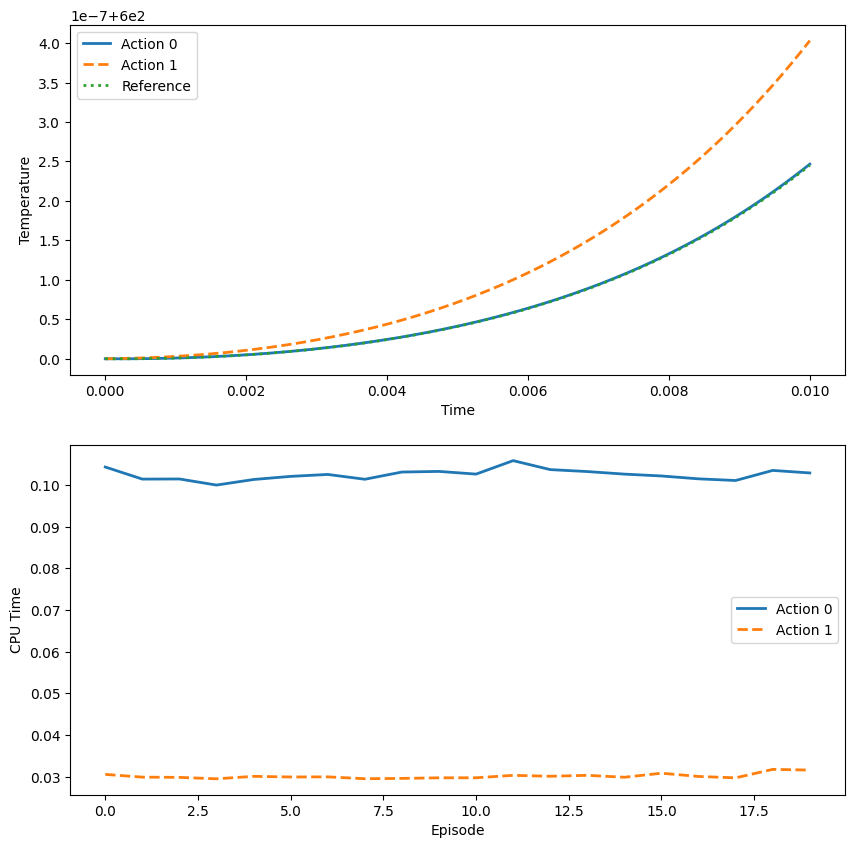

In [23]:
# compare all actions
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), dpi=100)
line_styles = ['-', '--', ':', '-.']
for action in all_action_comparison.keys():
    times = all_action_comparison[action]['times_trajectory']
    temp = np.array(all_action_comparison[action]['trajectory'])[:, 0]
    ax1.plot(times, temp, label='Action ' + str(action), linewidth=2, linestyle=line_styles[action])
    # plot reference
    
    ax2.plot(all_action_comparison[action]['cpu_times'], label='Action ' + str(action), linewidth=2, linestyle=line_styles[action])
ax1.plot(ref_time, ref_temp, label='Reference', linewidth=2, linestyle=':')
ax1.set_xlabel('Time')
ax1.set_ylabel('Temperature')
ax1.legend()

ax2.set_xlabel('Episode')
ax2.set_ylabel('CPU Time')
ax2.legend()
plt.show()

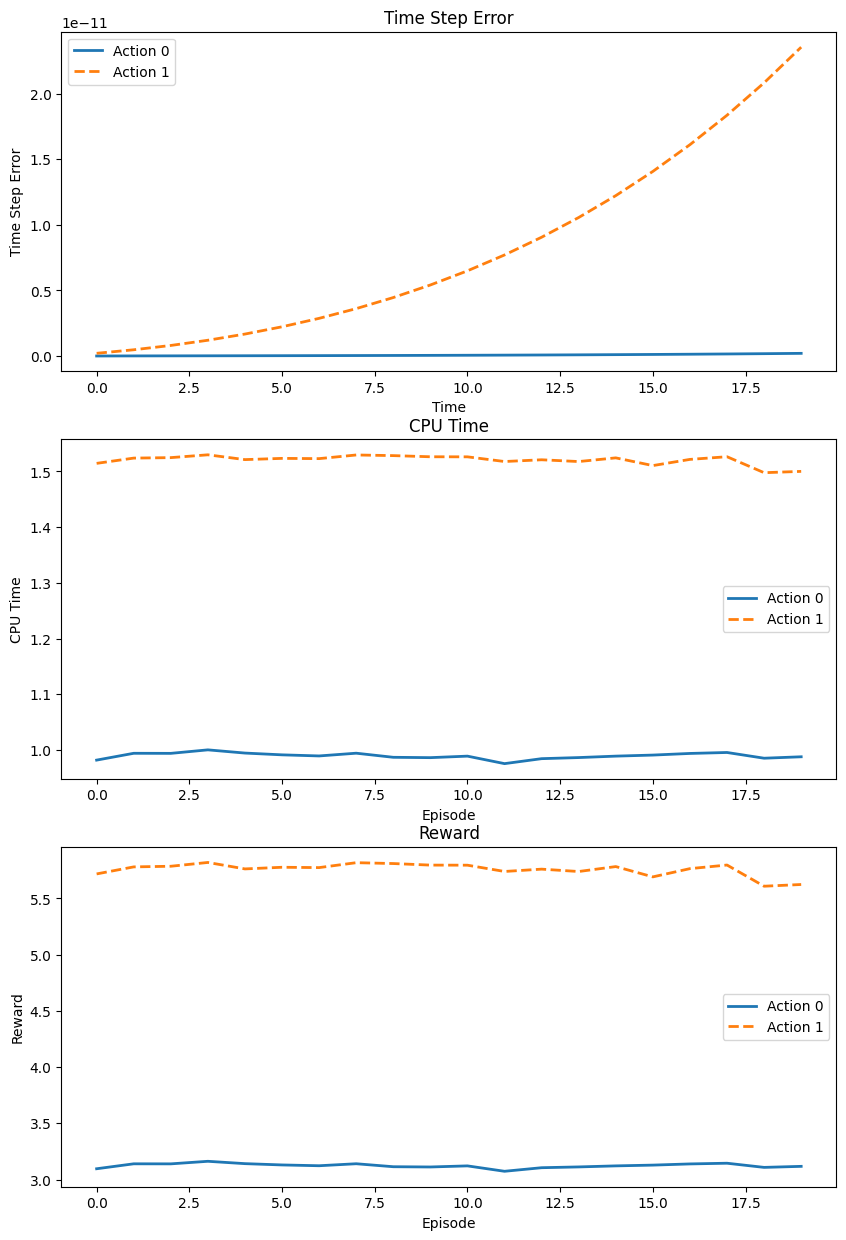

In [24]:
# compare all actions
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15), dpi=100)
line_styles = ['-', '--', ':', '-.']
for action in all_action_comparison.keys():
    times = all_action_comparison[action]['times_trajectory']
    time_step_error = all_action_comparison[action]['timestep_errors']
    reward = all_action_comparison[action]['rewards']
    ax1.plot(time_step_error, label='Action ' + str(action), linewidth=2, linestyle=line_styles[action])
    # plot reference
    
    ax2.plot(-np.log10(all_action_comparison[action]['cpu_times']), label='Action ' + str(action), linewidth=2, linestyle=line_styles[action])
    ax3.plot(reward, label='Action ' + str(action), linewidth=2, linestyle=line_styles[action])
# ax1.plot(ref_time, ref_temp, label='Reference', linewidth=2, linestyle='--')
ax1.set_xlabel('Time')
ax1.set_ylabel('Time Step Error')
ax1.legend()
ax1.set_title('Time Step Error')
ax2.set_xlabel('Episode')
ax2.set_ylabel('CPU Time')
ax2.legend()
ax2.set_title('CPU Time')
ax3.set_xlabel('Episode')
ax3.set_ylabel('Reward')
ax3.legend()
ax3.set_title('Reward')
plt.show()

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 8), dpi=200)
for action in all_action_comparison.keys():
    # plot the reward breakdown 
    rewards = all_action_comparison[action]['rewards']
    cpu_rewards = all_action_comparison[action]['cpu_rewards']
    accuracy_rewards = all_action_comparison[action]['accuracy_rewards']
    ax1.plot(rewards, label='Action ' + str(action), linewidth=2, linestyle=line_styles[action])
    ax2.plot(cpu_rewards, label='Action ' + str(action), linewidth=2, linestyle=line_styles[action])
    ax3.plot(accuracy_rewards, label='Action ' + str(action), linewidth=2, linestyle=line_styles[action])

ax1.set_title('Reward')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Reward')
ax1.legend()

ax2.set_title('CPU Time')
ax2.set_xlabel('Episode')
ax2.set_ylabel('CPU Time')
ax2.legend()

ax3.set_title('Accuracy Reward')
ax3.set_xlabel('Episode')
ax3.set_ylabel('Accuracy Reward')
ax3.legend()

In [ ]:
all_action_comparison[2]['rewards']

In [ ]:
all_action_comparison[2]['rewards']


In [ ]:
all_action_comparison[2]['timestep_errors']

In [ ]:
# plot the timestep error and cumulative error
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), dpi=100)
for action in all_action_comparison.keys():
    timestep_errors = all_action_comparison[action]['timestep_errors']
    cumulative_errors = all_action_comparison[action]['cumulative_errors']
    ax1.plot(np.log10(timestep_errors), label='Action ' + str(action), linewidth=2, linestyle=line_styles[action])
    ax2.plot(np.log10(cumulative_errors), label='Action ' + str(action), linewidth=2, linestyle=line_styles[action])

ax1.set_xlabel('Episode')
ax1.set_ylabel('Timestep Error')
ax2.set_ylabel('Cumulative Error')
ax1.legend()
ax2.legend()
plt.show()

In [29]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import sys
import time


In [34]:
class LagrangeReward1:
    """
    Constrained reward: minimize CPU with error <= epsilon.
    The dual variable lambda_ is adapted online (dual ascent).
    """
    def __init__(self, epsilon=1e-3, 
                 lambda_init=1.0, 
                 lambda_lr=0.05, 
                 target_violation=0.0,
                 cpu_log_delta=1e-3, 
                 reward_clip=50.0):
        self.epsilon = float(epsilon)
        self.lambda_ = float(lambda_init)
        self.lambda_lr = float(lambda_lr)
        self.target_violation = float(target_violation)
        self.cpu_log_delta = float(cpu_log_delta)
        self.reward_clip = float(reward_clip)
        self._violations = []

    def reset_episode(self):
        self._violations = []

    def step_reward(self, cpu_time, err):
        # CPU term: larger when faster; use log for smoothness and scale
        cpu_term = -np.log(cpu_time + self.cpu_log_delta)

        # Violation: zero if below epsilon; linear above
        violation = max(err / (self.epsilon + 1e-12) - 1.0, 0.0)
        self._violations.append(violation)

        r = cpu_term - self.lambda_ * violation
        return float(np.clip(r, -self.reward_clip, self.reward_clip))

    def end_episode_update_lambda(self):
        if not self._violations:
            return
        avg_violation = float(np.mean(self._violations))
        # Dual ascent with nonnegativity
        self.lambda_ = max(0.0, self.lambda_ + self.lambda_lr * (avg_violation - self.target_violation))
        self._violations = []

    def get_aux(self):
        return {"lambda": self.lambda_, "epsilon": self.epsilon}

class SigmoidBlendReward:
    """
    Smoothly switches between accuracy and CPU optimization using a sigmoid gate
    with hysteresis margin.
    """
    def __init__(self, epsilon=1e-3, beta=6.0, margin_decades=0.5,
                 cpu_log_delta=1e-3, reward_clip=50.0):
        self.epsilon = float(epsilon)
        self.beta = float(beta)
        self.margin_decades = float(margin_decades)  # how many log10 decades below eps to switch
        self.cpu_log_delta = float(cpu_log_delta)
        self.reward_clip = float(reward_clip)
        self._ema_gate = None  # optional smoothing

    def reset_episode(self):
        self._ema_gate = None

    def _gate(self, err):
        # gate on log-error ratio; positive when err < epsilon
        s = np.log10((self.epsilon + 1e-12) / (err + 1e-12)) - self.margin_decades
        w = 1.0 / (1.0 + np.exp(-self.beta * s))  # in (0,1)
        # small EMA to avoid chattering
        if self._ema_gate is None:
            self._ema_gate = w
        else:
            self._ema_gate = 0.8 * self._ema_gate + 0.2 * w
        return float(self._ema_gate)

    def step_reward(self, cpu_time, err):
        w = self._gate(err)
        cpu_term = -np.log(cpu_time + self.cpu_log_delta)
        acc_term = -np.log1p(err / (self.epsilon + 1e-12))
        r = w * cpu_term + (1.0 - w) * acc_term
        return float(np.clip(r, -self.reward_clip, self.reward_clip))

    def end_episode_update_lambda(self):
        pass  # no dual var here

    def get_aux(self):
        return {"gate": self._ema_gate}


class LagrangeReward2:
    def __init__(self, epsilon=1e-3, 
                 lambda_init=1.0, lambda_lr=0.05, target_violation=0.0,
                 cpu_log_delta=1e-3, reward_clip=30.0,
                 ema_alpha=0.9,              # EMA for violation
                 use_squared_hinge=True,     # stronger hit on large errors
                 lambda_max=1e3):            # keep λ bounded
        self.epsilon = float(epsilon)
        self.lambda_ = float(lambda_init)
        self.lambda_lr = float(lambda_lr)
        self.target_violation = float(target_violation)
        self.cpu_log_delta = float(cpu_log_delta)
        self.reward_clip = float(reward_clip)
        self.ema_alpha = float(ema_alpha)
        self.use_squared_hinge = bool(use_squared_hinge)
        self.lambda_max = float(lambda_max)
        self._violations = []
        self._ema_v = None

    def reset_episode(self):
        self._violations = []
        self._ema_v = None

    def _violation(self, err):
        v = max(err / (self.epsilon + 1e-12) - 1.0, 0.0)
        if self.use_squared_hinge:
            v = v * v                      # bigger slap once above ε
        return v

    def step_reward(self, cpu_time, err):
        v = self._violation(err)
        self._violations.append(v)
        # EMA of violation (captures drift)
        self._ema_v = v if self._ema_v is None else self.ema_alpha*self._ema_v + (1-self.ema_alpha)*v

        cpu_term = -np.log(cpu_time + self.cpu_log_delta)
        # penalize both instantaneous and smoothed violation
        penalty = self.lambda_ * (0.5*v + 0.5*(self._ema_v or 0.0))
        r = cpu_term - penalty
        return float(np.clip(r, -self.reward_clip, self.reward_clip))

    def end_episode_update_lambda(self):
        if not self._violations:
            return
        avg_v = float(np.mean(self._violations))
        # “PI” dual ascent: proportional + integral via the avg across episode
        self.lambda_ = min(self.lambda_max, max(0.0, self.lambda_ + self.lambda_lr*(avg_v - self.target_violation)))
        self._violations = []

    def get_aux(self):
        return {"lambda": self.lambda_, "epsilon": self.epsilon}


In [76]:
# load all_action_comparison from a pickle file
with open('all_action_comparison.pkl', 'rb') as f:
    all_action_comparison = pickle.load(f)

In [77]:
cvode_cpu_times = all_action_comparison[0]['cpu_times']
qss_cpu_times = all_action_comparison[1]['cpu_times']

cvode_time_error = all_action_comparison[0]['timestep_errors']
qss_time_error = all_action_comparison[1]['timestep_errors']

cvode_reward = all_action_comparison[0]['rewards']
qss_reward = all_action_comparison[1]['rewards']



In [100]:
from collections import deque
class AugLagReward:
    """
    r = -log(cpu_norm) - λ v - 0.5 ρ v^2
    with online updates of λ and ρ.
    """
    def __init__(self, epsilon=1e-3, cpu_log_delta=1e-3,
                 reward_clip=30.0, lambda_init=1.0, rho_init=1.0,
                 lambda_max=1e4, rho_max=1e4, 
                 target_violation=0.0,   # avg desired violation
                 k_update=1,             # update cadence (steps)
                 ema_alpha=0.9):
        self.epsilon = float(epsilon)
        self.cpu_log_delta = float(cpu_log_delta)
        self.reward_clip = float(reward_clip)
        self.lambda_ = float(lambda_init)
        self.rho = float(rho_init)
        self.lambda_max = float(lambda_max)
        self.rho_max = float(rho_max)
        self.target_violation = float(target_violation)
        self.k_update = int(k_update)
        self.ema_alpha = float(ema_alpha)

        self._step = 0
        self._ema_v = 0.0
        self._cpu_med = 0.02  # running scale for normalization
        self._cpu_hist = deque(maxlen=128)

    def reset_episode(self):
        self._step = 0
        self._ema_v = 0.0
        self._cpu_hist.clear()

    def _violation(self, err):
        # squared hinge → stronger penalty above epsilon
        x = max(err/(self.epsilon + 1e-12) - 1.0, 0.0)
        return x*x

    def _cpu_norm_term(self, cpu_time):
        # normalize by running median so scales are comparable across scenarios
        self._cpu_hist.append(cpu_time)
        if len(self._cpu_hist) >= 8:
            self._cpu_med = np.median(self._cpu_hist)
        cpu_norm = cpu_time / max(self._cpu_med, 1e-3)
        return -np.log(cpu_norm + self.cpu_log_delta)

    def step_reward(self, cpu_time, local_err):
        v = self._violation(local_err)
        self._ema_v = self.ema_alpha*self._ema_v + (1-self.ema_alpha)*v

        cpu_term = self._cpu_norm_term(cpu_time)
        r = cpu_term - self.lambda_*v - 0.5*self.rho*(v**2)
        r = float(np.clip(r, -self.reward_clip, self.reward_clip))

        # online parameter update every k steps
        self._step += 1
        if self._step % self.k_update == 0:
            # dual ascent with augmented term; increase rho when needed
            # lambda ← [lambda + rho*(ema_v - target)]_+
            self.lambda_ = min(self.lambda_max, max(0.0, self.lambda_ + self.rho*(self._ema_v - self.target_violation)))
            # if we are persistently violating, grow rho to escalate penalties
            if self._ema_v > self.target_violation + 1e-4:
                self.rho = min(self.rho_max, self.rho * 1.05)  # gently ramp up
            else:
                self.rho = max(1e-3, self.rho * 0.995)          # gentle decay

        return r

    def end_episode_update(self):
        # optional: nothing required because we already update online
        pass

    def get_aux(self):
        return {"lambda": self.lambda_, "rho": self.rho, "cpu_med": self._cpu_med}

aug_lag_reward_config = {
        'epsilon': 1e-4,
        'cpu_log_delta': 1e-3,
        'reward_clip': 5.0,
        'lambda_init': 1.0,
        'rho_init': 1.0,
        'lambda_max': 1e4,
        'rho_max': 1e4,
        'target_violation': 0.0,
        'k_update': 1,
        'ema_alpha': 0.9
    }
reward_function4 = AugLagReward(**aug_lag_reward_config)

In [116]:
reward_config1 = {
        'epsilon': 1e-5,
        'lambda_init': 1.0,
        'lambda_lr': 0.05,
        'target_violation': 0.0,
        'cpu_log_delta': 1e-3,
        'reward_clip': 5.0
    }
reward_config2 = {
        'epsilon': 1e-3,
        'lambda_init': 1.0,
        'lambda_lr': 0.05,
        'target_violation': 0.0,
        'cpu_log_delta': 1e-3,
        'reward_clip': 10.0,
        'ema_alpha': 0.9,
        'use_squared_hinge': True,
        'lambda_max': 1e3
    }
    
sigmoid_reward_config = {
    'epsilon': 1e-3,
    'beta': 6.0,
    'margin_decades': 0.1,
    'cpu_log_delta': 1e-3,
    'reward_clip': 10.0
}
reward_function3 = SigmoidBlendReward(**sigmoid_reward_config)

reward_function1 = LagrangeReward1(**reward_config1)
reward_function2 = LagrangeReward2(**reward_config2)



In [117]:
cvode_reward = []
qss_reward = []


for j in range(max(len(cvode_cpu_times), len(qss_cpu_times))):
    if j < len(cvode_cpu_times):
        cvode_reward.append(reward_function1.step_reward(cvode_cpu_times[j], cvode_time_error[j]))
    if j < len(qss_cpu_times):
        qss_reward.append(reward_function1.step_reward(qss_cpu_times[j], qss_time_error[j]))
      


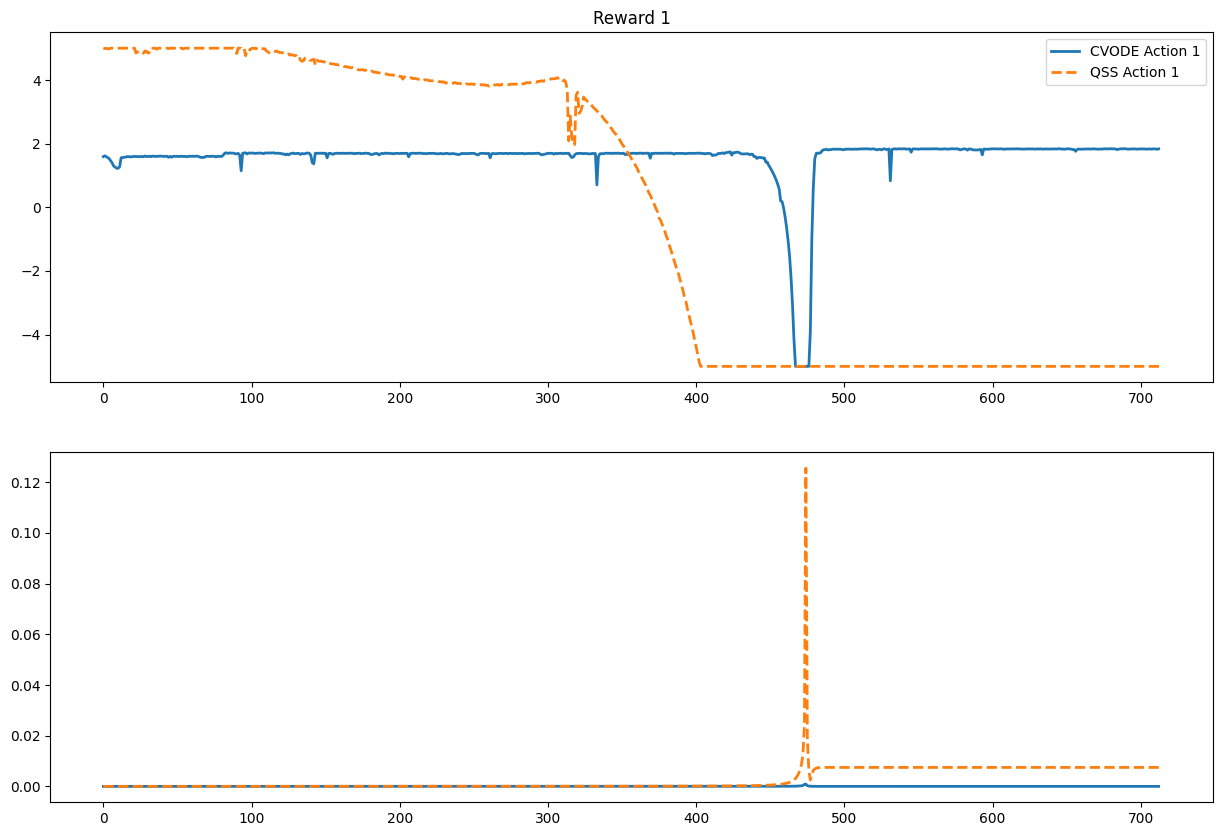

In [118]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), dpi=100)



line_styles = ['-', '--', ':', '-.', '--', ':', '-.']
ax1.plot(cvode_reward, label='CVODE Action ' + str(1), linewidth=2, linestyle=line_styles[0])
ax1.plot(qss_reward, label='QSS Action ' + str(1), linewidth=2, linestyle=line_styles[1])


ax2.plot(cvode_time_error, label='CVODE Action ' + str(1), linewidth=2, linestyle=line_styles[0])
ax2.plot(qss_time_error, label='QSS Action ' + str(1), linewidth=2, linestyle=line_styles[1])
ax1.set_title('Reward 1')
ax1.legend()
plt.show()

In [4]:
import numpy as np
np.log10(6)

np.float64(0.7781512503836436)